In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from torchvision.models import resnet18, ResNet18_Weights

import numpy as np
from collections import deque, namedtuple
import random
from itertools import count

import matplotlib
import matplotlib.pyplot as plt

import gymnasium as gym

import os

from NaturalEnv import natural_env_v0

is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

device

device(type='cuda')

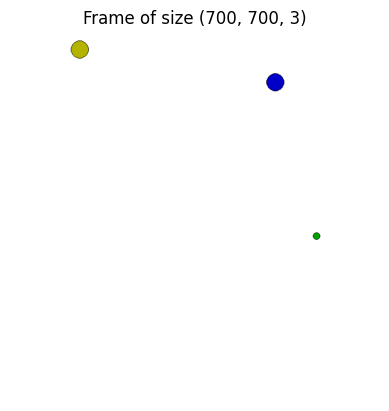

In [2]:
env = natural_env_v0.parallel_env(render_mode="rgb_array", max_cycles=100, num_predators=0, num_prey=1,
                                  num_obstacles = 0, num_food=1, num_water=1, num_forests=0)

observations, infos = env.reset()

# Obtain a screenshot of the environment
observation = env.render()

# Show the observation
plt.imshow(observation)
plt.axis('off')
plt.title(f"Frame of size {observation.shape}")
plt.show()

# Get the size of the action space
nn_input_size = observation.shape
num_actions = env.action_space("prey_0").n

frame = torch.FloatTensor(observation).permute(2, 0, 1).reshape(1, 3, 700, 700)

# Fine tune a CNN model
model = resnet18(weights=ResNet18_Weights.IMAGENET1K_V1)
model.fc = nn.Linear(model.fc.in_features, num_actions)

# Only train the last layer
for param in model.parameters():
    param.requires_grad = False

for param in model.fc.parameters():
    param.requires_grad = True

model.to(device)


# Changes the batches into the correct format for the DQN
Transition = namedtuple('Transition', ('state', 'action', 'reward', 'next_state', 'done'))

# Create a model for reinforcement learning
class DQN(nn.Module):
    def __init__(self, model):
        super().__init__()
        self.model = model

    def forward(self, x):
        return self.model(x)
    
# Keeps the memory of previous steps, and gives ways to access it quickly
class ReplayMemory(object):
    def __init__(self, capacity):
        self.memory = deque([], maxlen=capacity)

    def push(self, *args):
        self.memory.append(Transition(*args))

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

In [3]:
batch_size = 128  # Number of transitions sampled from replay buffer

epsilon = 1.0  # Exploration rate
epsilon_min = 0.05  # Minimum exploration rate
epsilon_decay = 0.995  # Exploration decay rate

lr = 0.01  # Learning rate
gamma = 0.99  # Discount factor
tau = 0.0005  # Target network update rate

steps_done = 0 

policy_net = DQN(model).to(device)
target_net = DQN(model).to(device)
target_net.load_state_dict(policy_net.state_dict())

# Keeps record of previous steps in a batch
memory = {agent_name: ReplayMemory(10000) for agent_name in env.agents}

optimizer = optim.Adam(policy_net.parameters(), lr=lr, amsgrad=True)

In [4]:
def choose_action(observation, action_space, epsilon, explotation=False):
    global steps_done
    sample = random.random()
    
    steps_done += 1

    if explotation:
        with torch.no_grad():
            return policy_net(observation).max(1)[1].view(1, 1)
    elif sample > epsilon:
        with torch.no_grad():
            return policy_net(observation).max(1)[1].view(1, 1)
    else:
        return torch.tensor([[action_space.sample()]], device=device, dtype=torch.long)

def learn(agent):
    """
    Function that performs a learning step using DQN
    """
    if len(memory[agent]) < batch_size:
        return

    transitions = memory[agent].sample(batch_size)
    batch = Transition(*zip(*transitions))

    non_final_mask = torch.tensor(tuple(map(lambda s: s is not None, batch.next_state)), device=device, dtype=torch.bool)
    non_final_next_states = torch.cat([s for s in batch.next_state if s is not None])

    state_batch = torch.cat(batch.state)
    action_batch = torch.cat(batch.action)
    reward_batch = torch.cat(batch.reward)

    state_action_values = policy_net(state_batch).gather(1, action_batch)

    next_state_values = torch.zeros(batch_size, device=device)
    with torch.no_grad():
        next_state_values[non_final_mask] = target_net(non_final_next_states).max(1).values

    expected_state_action_values = (next_state_values * gamma) + reward_batch

    loss = F.smooth_l1_loss(state_action_values, expected_state_action_values.unsqueeze(1))

    optimizer.zero_grad()
    loss.backward()
    torch.nn.utils.clip_grad_value_(policy_net.parameters(), 200)
    optimizer.step()

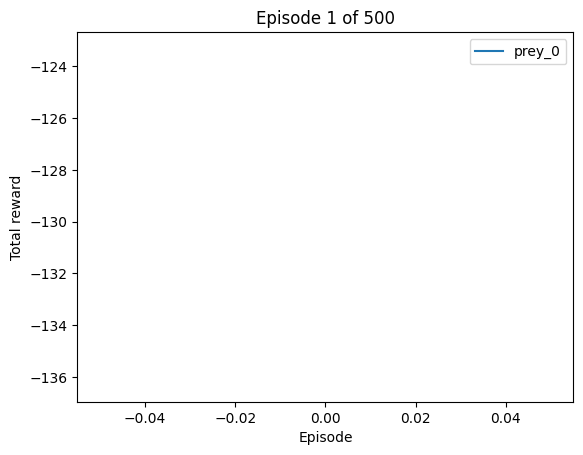

<Figure size 640x480 with 0 Axes>

In [ ]:
reward_history = {agent_name: [] for agent_name in env.agents}
agent_names = list(env.agents)

max_rewards = {agent_name: 0 for agent_name in env.agents}

plt.ion()

def update_plot_multi_agent(episode, max_episodes, show_result=False):
    plt.figure(1)

    if show_result:
        plt.title(f'Final Result:')
    else:
        plt.clf()
        plt.title(f"Episode {episode} of {max_episodes}")
    plt.xlabel('Episode')
    plt.ylabel('Total reward')

    for agent_name in agent_names:
        agent_name = agent_names[0]
        rewards_t = torch.tensor(reward_history[agent_name], dtype=torch.float)
        plt.plot(rewards_t.numpy(), label=agent_name)

        # Plot moving average of last 10 rewards
        if len(rewards_t) >= 10:
            means = rewards_t.unfold(0, 10, 1).mean(1).view(-1)
            means = torch.cat((torch.zeros(9), means))
            plt.plot(means.numpy())            

    plt.legend()
    plt.pause(0.001)
    if is_ipython:
        if not show_result:
            display.display(plt.gcf())
            display.clear_output(wait=True)
        else:
            display.display(plt.gcf())

max_episodes = 500

for episode in range(max_episodes):
    state, info = env.reset()

    observation = env.render()  

    frame = torch.FloatTensor(observation).to(device).permute(2, 0, 1).reshape(1, 3, 700, 700)

    # Get the total reward for each agent
    total_reward = {agent_name: 0 for agent_name in env.agents}
    episode_over = False

    # Keep going
    while True:
        actions = {}
        actions_tensors = {}
        # Choose actions for each agent
        for agent_name in env.agents:
            action = choose_action(frame, env.action_space(agent_name), epsilon)
            actions[agent_name] = action.item()
            actions_tensors[agent_name] = action


        # Do all actions at the same time
        observation, reward, terminated, truncated, info = env.step(actions)

        obs = env.render()
        next_frame = torch.FloatTensor(obs).to(device).permute(2, 0, 1).reshape(1, 3, 700, 700)

        if all(terminated.values()) or all(truncated.values()):
            episode_over = True
            for agent_name in env.agents:
                total_reward[agent_name] += reward[agent_name]
        else:
            # Get the results of the actions for each agent
            for agent_name in env.agents:
                
                total_reward[agent_name] += reward[agent_name]


                # Convert the reward in a tensor
                reward = torch.tensor([reward[agent_name]], device=device)
                #done = torch.tensor([episode_over], device=device)

                memory[agent_name].push(frame, actions_tensors[agent_name], reward, next_frame, episode_over)

                learn(agent_name)
        frame = next_frame


        epsilon = max(epsilon_min, epsilon * epsilon_decay)

        # Update the target network
        target_net_state_dict = target_net.state_dict()
        policy_net_state_dict = policy_net.state_dict()
        for key in policy_net_state_dict:
            target_net_state_dict[key] = policy_net_state_dict[key] * (tau) + target_net_state_dict[key] * (1 - tau)
        target_net.load_state_dict(target_net_state_dict)
    
        # End if any agent has a problem or the max_steps are taken
        if episode_over:
            reward_history[agent_name].append(total_reward[agent_name])
            break

    update_plot_multi_agent(episode + 1, max_episodes)

update_plot_multi_agent(episode + 1, max_episodes, show_result=True)
plt.ioff()
plt.show()

In [ ]:
env_human = natural_env_v0.parallel_env(render_mode="human", max_cycles=100, num_predators=0, num_prey=1,
                                  num_obstacles = 0, num_food=1, num_water=1, num_forests=0)

for episode in range(2):
    state, info = env_human.reset()

    frame = {}
    # Get the initial frame for each agent
    for agent_name in env_human.agents:
        frame[agent_name] = torch.tensor(state[agent_name], dtype=torch.float32, device=device).unsqueeze(0)

    # Get the total reward for each agent
    episode_over = False

    # Keep going
    while True:
        actions = {}
        # Choose actions for each agent
        for agent_name in env_human.agents:
            action = choose_action(frame[agent_name], env_human.action_space(agent_name), epsilon, explotation=True)
            actions[agent_name] = action.item()


        # Do all actions at the same time
        observation, reward, terminated, truncated, info = env_human.step(actions)

        if all(terminated.values()) or all(truncated.values()):
            episode_over = True
        else:
            # Get the results of the actions for each agent
            for agent_name in env_human.agents:
                # Save the observation in a tensor
                frame[agent_name] = torch.tensor(observation[agent_name], dtype=torch.float32, device=device).unsqueeze(0)
    
        # End if any agent has a problem or the max_steps are taken
        if episode_over:
            break


env_human.close()